This file contains (almost) all of the runnable code in the project, merged together to form a pipeline.

*Importations, Prerequisites and Configurations*

In [31]:
import re
import json
import os
import shutil
from tqdm import tqdm
import spacy
from spacy import displacy
import aiohttp
import asyncio
from tqdm.asyncio import tqdm_asyncio
import gc
from transformers import GPT2TokenizerFast
from tokenizers import ByteLevelBPETokenizer
import multiprocessing as mp
from itertools import islice
from multiprocessing import cpu_count, Pool
import math
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
import numpy as np
from gensim.models import Word2Vec
import logging
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text
from functools import partial

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


base_dir = '.'
origin_dir = '' # Directory where unparsed pdf files are located
destination_dir = './pdf_parsed' # Directory of parsed pdf files
vocab_dir = './vocab'
tokenized_dir = './tokenized'

os.makedirs(vocab_dir,exist_ok=True)
os.makedirs(tokenized_dir,exist_ok=True)

\[optional, run if using scispacy]
```bash
pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz
```
12 GiB of memory needed

# Part 1: Parsing the Data

Due to limit of system memory, we decided to use only 10000 papers

In [4]:
if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)
os.makedirs(destination_dir, exist_ok=True)

for filename in tqdm(os.listdir(origin_dir)[:10000]):
    with open(os.path.join(origin_dir, filename), 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        paper_id = json_data['paper_id']
        title = json_data['metadata']['title']
        abstract = json_data['abstract'][0]['text'] if json_data['abstract'] else ''
        body_text_raw = json_data['body_text']
        body_text = ''
        for segment in body_text_raw:
            raw_text = segment['text']
            for cite in segment['cite_spans']:
                if cite['ref_id'] != '':
                    raw_text = raw_text.replace(cite['text'], '')
            body_text += raw_text.strip() + '\n'
        body_text = re.sub(r'\\u[0-9a-fA-F]{4}', '', body_text)
        body_text_purged = re.sub(r'\[\d+]', '', body_text)

    with open(os.path.join(destination_dir, paper_id + '.txt'), 'w', encoding='utf-8') as f:
        f.write(title + '\n')
        f.write(abstract + '\n')
        f.write(body_text_purged + '\n')

100%|██████████| 10000/10000 [01:44<00:00, 95.50it/s] 


# Part2: Tokenization

## Track2.1 Using Split

In [5]:
def tokenize_text_split(file_path, destination, remove_punctuation=True, write_to_file=False):
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()

    # Remove punctuation
    if remove_punctuation:
        words = re.split(r'\W+', content)
    else:
        words = content.split()
    print(words[:50])
    if write_to_file:
        if not os.path.exists(destination):
            os.makedirs(destination, exist_ok=True)

        with open(os.path.join(destination, 'split.txt'), "w", encoding="utf-8") as f:
            f.write("\n".join(words))
    return words

## Track2.2: Using SciSpaCy

In [6]:
def tokenize_text_spacy(text):
    nlp = spacy.load('en_core_sci_lg')
    doc = nlp(text)
    return doc

## Track2.3: Using BPE Encoding

In [7]:
def tokenize_text_BPE(input_file, destination, write_to_file=True):
    # Initialize the tokenizer
    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    print("Tokenizer initialized.")

    # Read the file
    with open(os.path.join(input_file, 'merged.txt'), 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Tokenize the text
    tokens = []
    for line in tqdm(lines, desc="Tokenizing"):
        tokens.extend(tokenizer.tokenize(line, truncation=True, max_length=512))

    # Convert tokens to token IDs
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Write to file
    if write_to_file:
        if not os.path.exists(destination):
            os.makedirs(destination, exist_ok=True)

        with open(path.join(destination, 'tokens.txt'), 'w', encoding='utf-8') as file:
            for token in tqdm(tokens, desc="Writing tokens"):
                file.write(token+ "\n")
        with open(path.join(destination, 'token_ids.txt'), 'w', encoding='utf-8') as file:
            for token_id in tqdm(token_ids, desc="Writing token IDs"):
                file.write(str(token_id) + "\n")

    return tokens, token_ids

## Track 2.4: Build Our Own BPE

This track consists of two subsections, the training section and the tokenizing function.

Training may take some time, monitor CPU status to see if training process is running.

The tokenizer is **CPU multiprocess optimized** for processing large amount of files. Ensure that there is enough disk space.

Or if the training process is taking too long, you can directly use the model under `/vocab/`

In [12]:
# Training

save_model = True

vocab_size = 10000

def train_tokenizer(input_files, vocab_dir, vocab_size=10000):
    """Train BPE tokenizer on large file"""
    tokenizer = ByteLevelBPETokenizer()
    # Train tokenizer first
    tokenizer.train(
        files=input_files,
        vocab_size=vocab_size,
        min_frequency=5,
        special_tokens=['<pad>', '<unk>', '<cls>', '<sep>']
    )
    if save_model:
        prompt = input('Sure to save model? [y/N]: ')
        if not prompt in ['Y','y']:
            return 0
    tokenizer.save_model(vocab_dir)
    return tokenizer

file_list = [os.path.join(destination_dir,filename) for filename in os.listdir(destination_dir)]
train_tokenizer(file_list,vocab_dir,vocab_size)

Sure to save model? [y/N]:  y


Tokenizer(vocabulary_size=10000, model=ByteLevelBPE, add_prefix_space=False, lowercase=False, dropout=None, unicode_normalizer=None, continuing_subword_prefix=None, end_of_word_suffix=None, trim_offsets=False)

In [13]:
# Tokenizing

merge = True

def tokenize_chunk(chunk_args):
    string, tokenizer_path = chunk_args
    ids, tokens = tokenize_string(string, tokenizer_path)
    return tokens

def tokenize_string(string, tokenizer_path):
    """Tokenize a file chunk"""
    tokenizer = ByteLevelBPETokenizer.from_file(os.path.join(tokenizer_path,'vocab.json'),
                                                os.path.join(tokenizer_path,'merges.txt'))
    encoded = tokenizer.encode(string)
    return encoded.ids, encoded.tokens

def write_tokenized_file(output_dir:str, input_file:str, vocab_dir:str, chunk_size = 10*1024*1024):
    # Prepare output file
    output_file = os.path.join(output_dir, 'tokenized_essays.txt')

    # Multiprocessing setup

    tokenizer_path = os.path.join(output_dir, 'tokenizer')
    with open(input_file, 'r', encoding='utf-8') as f, \
            open(output_file, 'w', encoding='utf-8') as out_f:
        pool = mp.Pool(processes=min(32,cpu_count()))

        # Stream and tokenize chunks
        chunks = iter(lambda: f.read(chunk_size), '')
        chunk_args = [(chunk, vocab_dir) for chunk in chunks]

        for tokenized_chunk in tqdm(pool.imap(tokenize_chunk, chunk_args)):
            out_f.write(' '.join(map(str, tokenized_chunk)) + '\n')

    print(f"Large file tokenization complete. Output in {output_file}")


def process_chunk(args):
    """Process a chunk of files and save to a temporary output file"""
    chunk_files, destination_dir, tokenizer_path, tokenized_dir, chunk_id = args

    # Initialize tokenizer for this process
    tokenizer = ByteLevelBPETokenizer.from_file(
        os.path.join(tokenizer_path, 'vocab.json'),
        os.path.join(tokenizer_path, 'merges.txt')
    )

    # Create output file for this chunk
    output_path = os.path.join(tokenized_dir, f'tokenized_chunk_{chunk_id}.txt')
    with open(output_path, 'w') as output_file:
        for filename in tqdm(chunk_files):
            with open(os.path.join(destination_dir, filename), 'r', encoding='utf-8') as f:
                context = f.read()
            encoded = tokenizer.encode(context)
            output_file.write(' '.join(encoded.tokens) + '\n')

    return output_path


def merge_files(chunk_files, output_file):
    """Merge all chunk files into final output file"""
    with open(output_file, 'w') as outfile:
        for chunk_file in tqdm(chunk_files, desc="Merging files"):
            with open(chunk_file, 'r') as infile:
                outfile.write(infile.read())
            # Clean up chunk file
            os.remove(chunk_file)


def main_tokenizer():
    tokenizer_path = vocab_dir
    os.makedirs(tokenized_dir, exist_ok=True)

    # Get list of all files
    all_files = os.listdir(destination_dir)

    # Calculate chunk size based on number of CPU cores
    num_cores = min(32, cpu_count())
    chunk_size = math.ceil(len(all_files) / num_cores)

    # Create chunks of files
    file_chunks = []
    for i in range(0, len(all_files), chunk_size):
        chunk = list(islice(all_files, i, i + chunk_size))
        file_chunks.append((chunk, destination_dir, tokenizer_path, tokenized_dir, i // chunk_size))

    # Process chunks in parallel with better progress tracking
    print(f"Processing {len(all_files)} files using {num_cores} cores...")
    chunk_files = []
    with mp.Pool(num_cores) as pool:
        results = pool.map_async(process_chunk, file_chunks)
        chunk_files = results.get()

    # Merge all chunk files into final output
    print("Merging chunk files...")
    merge_files(chunk_files, os.path.join(tokenized_dir, 'merged_tokenized.txt'))
    print("Done!")


if __name__ == '__main__':
    main_tokenizer()


Processing 10000 files using 32 cores...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Merging chunk files...


Merging files: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]

Done!


# Part3: Build Word Representation

## Track 3.1: n-gram

This track may not properly run on all machines due to lack of system memory

(We tried it on a smaller file and it worked fine. Anyway, we are using track 3.2 in the end :D)

In [15]:
class NgramVectorizer:
    def __init__(self, n: int = 3, vector_size: int = 256, learning_rate: float = 0.01):
        self.n = n  # n-gram size
        self.vector_size = vector_size
        self.learning_rate = learning_rate
        self.vocabulary = {}  # 词汇表
        self.ngram_counts = defaultdict(Counter)  # n-gram计数
        self.word_vectors = {}  # 词向量存储
        self.total_ngrams = 0

    def _get_ngrams(self, text: str) -> List[str]:
        """生成文本的n-gram"""
        padded = f"<s>{text}</s>"
        return [padded[i:i+self.n] for i in range(len(padded)-self.n+1)]

    def _build_vocabulary(self, tokens: List[str]) -> None:
        """构建词汇表"""
        unique_tokens = set(tokens)
        self.vocabulary = {token: idx for idx, token in enumerate(unique_tokens)}

    def _initialize_vectors(self):
        """初始化词向量"""
        for token in self.vocabulary.keys():
            # 使用随机初始化
            self.word_vectors[token] = np.random.randn(self.vector_size) * 0.1

    def _train_epoch(self, tokens: List[str], epoch: int):
        """训练一个epoch"""
        print(f"Training epoch {epoch + 1}...")
        total_loss = 0

        for token in tqdm(tokens):
            # 获取当前词的n-grams
            ngrams = self._get_ngrams(token)
            current_vector = self.word_vectors[token].copy()

            # 计算ngram贡献
            ngram_vector = np.zeros(self.vector_size)
            for ngram in ngrams:
                positions = self._hash_ngram(ngram)
                for pos in positions:
                    ngram_vector[pos] += self.ngram_counts[token][ngram] / len(ngrams)

            # 计算损失并更新向量
            loss = np.sum((current_vector - ngram_vector) ** 2)
            total_loss += loss

            # 梯度更新
            gradient = 2 * (current_vector - ngram_vector)
            self.word_vectors[token] -= self.learning_rate * gradient

            # 归一化向量
            norm = np.linalg.norm(self.word_vectors[token])
            if norm > 0:
                self.word_vectors[token] = self.word_vectors[token] / norm

        return total_loss / len(tokens)

    def fit(self, tokens: List[str], epochs: int = 10) -> None:
        """训练模型"""
        print("Building vocabulary...")
        self._build_vocabulary(tokens)

        print("Calculating n-grams...")
        # 计算n-gram频率
        for token in tqdm(self.vocabulary.keys()):
            ngrams = self._get_ngrams(token)
            self.ngram_counts[token].update(ngrams)
            self.total_ngrams += len(ngrams)

        # 初始化词向量
        print("Initializing word vectors...")
        self._initialize_vectors()

        # 多轮训练
        print("Starting training...")
        for epoch in range(epochs):
            avg_loss = self._train_epoch(tokens, epoch)
            print(f"Epoch {epoch + 1}/{epochs} completed. Average loss: {avg_loss:.4f}")

    def _hash_ngram(self, ngram: str) -> List[int]:
        """将n-gram哈希到向量空间中的多个位置"""
        hash_val = hash(ngram)
        return [abs(hash_val + i) % self.vector_size for i in range(3)]

    def get_vector(self, token: str) -> np.ndarray:
        """获取词的向量表示"""
        return self.word_vectors.get(token, np.zeros(self.vector_size))

    def save_vectors(self, output_path: str) -> None:
        """保存词向量到文件"""
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(f"{len(self.vocabulary)} {self.vector_size}\n")
            for token, vector in self.word_vectors.items():
                vector_str = ' '.join(map(str, vector))
                f.write(f"{token} {vector_str}\n")

def main_ngram():
    # 获取tokens
    with open(os.path.join(tokenized_dir,'merged_tokenized.txt')) as f:
        tokens = f.read().split(' ')

    # 初始化N-gram向量化器
    vectorizer = NgramVectorizer(n=3, vector_size=256)

    # 训练模型（使用10个epochs）
    vectorizer.fit(tokens, epochs=10)

    # 保存词向量
    vectorizer.save_vectors('ngram_vectors.txt')

    # 示例：打印前几个词的向量
    print("\nExample word vectors:")
    for token in tokens[:5]:
        vector = vectorizer.get_vector(token)
        print(f"{token}: {vector[:5]}...")

main_ngram()

Building vocabulary...
Calculating n-grams...


100%|██████████| 10237/10237 [00:40<00:00, 250.77it/s]


Initializing word vectors...
Starting training...
Training epoch 1...


  1%|          | 669983/56948088 [01:47<2:30:32, 6230.88it/s]


KeyboardInterrupt: 

## Track 3.2: Skip-Gram

In [16]:
def preprocess_text(input_file, max_sentences=50000):
    """
    Preprocess the input text file and return sentences for Word2Vec training.
    Each sentence is a list of tokens.

    Args:
        input_file: Path to input file
        max_sentences: Maximum number of sentences to process
    """
    sentences = []

    with open(input_file, 'r', encoding='utf-8') as f:
        # Read the single line and split by Ċ (sentence separator)
        text = f.read().strip()
        raw_sentences = text.split('Ċ')[:max_sentences]  # Cut at specified index

        for sentence in tqdm(raw_sentences):
            # Split the sentence into tokens
            # Handle special tokens (Ġ represents space before token)
            tokens = []
            current_token = ''

            for char in sentence.strip().split():
                tokens.append(char)

            # Add the last token if it exists
            if current_token:
                tokens.append(current_token.lower())

            # Only add sentences that have tokens
            if tokens:
                sentences.append(tokens)

    return sentences


def train_word2vec(sentences, vector_size=256, window=5, min_count=5):
    """
    Train a Word2Vec model on the preprocessed sentences.

    Args:
        sentences: List of tokenized sentences
        vector_size: Dimensionality of word vectors
        window: Maximum distance between current and predicted word
        min_count: Minimum frequency of words to consider

    Returns:
        Trained Word2Vec model
    """
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=min(32,cpu_count()),
        sg=1,  # Skip-gram model
        compute_loss=True,
        negative=15,  # Increased negative sampling
        alpha=0.025,  # Initial learning rate
        min_alpha=0.0001,  # Final learning rate
        epochs=10,
    )

    return model


def main(input_file, output_model_path, max_sentences=50000):
    """
    Main function to process input file and train Word2Vec model.
    """
    # Process the input file
    print("Processing input file...")
    sentences = preprocess_text(input_file, max_sentences)

    print(f"Found {len(sentences)} sentences (max: {max_sentences})")
    print("Sample sentences:", sentences[:5])

    # Train the model
    print("\nTraining Word2Vec model using 32 CPU cores...")
    model = train_word2vec(sentences)

    # Print training loss if available
    if model.get_latest_training_loss() is not None:
        print(f"Final training loss: {model.get_latest_training_loss():.4f}")

    # Save the model
    model.save(output_model_path)
    print(f"\nModel saved to {output_model_path}")

    # Print some example similarities
    if len(model.wv.key_to_index) > 0:
        word = list(model.wv.key_to_index.keys())[5]
        print(f"\nExample similar words to '{word}':")
        similar_words = model.wv.most_similar(word, topn=5)
        for similar_word, score in similar_words:
            print(f"{similar_word}: {score:.4f}")


if __name__ == "__main__":
    input_file = os.path.join(tokenized_dir,'merged_tokenized.txt')
    output_model_path = "word2vec_model.model"
    main(input_file, output_model_path, max_sentences=50000)
    gc.collect()

Processing input file...


100%|██████████| 50000/50000 [00:09<00:00, 5381.63it/s]
2025-02-14 00:51:00,713 : INFO : collecting all words and their counts
2025-02-14 00:51:00,718 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Found 47979 sentences (max: 50000)
Sample sentences: [['The', 'Ġrole', 'Ġof', 'Ġnic', 'otin', 'ic', 'Ġreceptors', 'Ġin', 'ĠSARS', '-', 'CoV', '-', '2', 'Ġreceptor', 'ĠACE', '2', 'Ġexpression', 'Ġin', 'Ġintestinal', 'Ġepit', 'hel', 'ia'], ['Background', ':', 'ĠRecent', 'Ġevidence', 'Ġdemonstrated', 'Ġthat', 'Ġsevere', 'Ġacute', 'Ġrespiratory', 'Ġsyndrome', 'Ġcoronavirus', 'Ġ2', 'Ġ(', 'SARS', '-', 'CoV', '-', '2', ')', 'Ġpropag', 'ates', 'Ġin', 'Ġintestinal', 'Ġepithelial', 'Ġcells', 'Ġexpressing', 'ĠAn', 'gi', 'otensin', '-', 'Con', 'verting', 'ĠEn', 'z', 'yme', 'Ġ2', 'Ġ(', 'ACE', '2', '),', 'Ġimp', 'lying', 'Ġthat', 'Ġthese', 'Ġcells', 'Ġrepresent', 'Ġan', 'Ġimportant', 'Ġentry', 'Ġsite', 'Ġfor', 'Ġthe', 'Ġviral', 'Ġinfection', '.', 'ĠN', 'ic', 'otin', 'ic', 'Ġreceptors', 'Ġ(', 'n', 'AC', 'h', 'Rs', ')', 'Ġhave', 'Ġbeen', 'Ġput', 'Ġforward', 'Ġas', 'Ġpotential', 'Ġregul', 'ators', 'Ġof', 'Ġinflammation', 'Ġand', 'Ġof', 'ĠACE', '2', 'Ġexpression', '.', 'ĠAs', 'Ġvag', 'us', 'Ġnerve', 'Ġs

2025-02-14 00:51:03,427 : INFO : PROGRESS: at sentence #10000, processed 1653806 words, keeping 9799 word types
2025-02-14 00:51:06,209 : INFO : PROGRESS: at sentence #20000, processed 3286412 words, keeping 9852 word types
2025-02-14 00:51:09,029 : INFO : PROGRESS: at sentence #30000, processed 4931921 words, keeping 9880 word types
2025-02-14 00:51:11,722 : INFO : PROGRESS: at sentence #40000, processed 6526374 words, keeping 9889 word types
2025-02-14 00:51:13,963 : INFO : collected 9896 word types from a corpus of 7828629 raw words and 47979 sentences
2025-02-14 00:51:13,969 : INFO : Creating a fresh vocabulary
2025-02-14 00:51:14,132 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 9832 unique words (99.35% of original 9896, drops 64)', 'datetime': '2025-02-14T00:51:14.131853', 'gensim': '4.3.2', 'python': '3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:46:43) [GCC 11.2.0]', 'platform': 'Linux-5.4.0-155-generic-x86_64-with-glibc2.35', 'event':

Final training loss: 28568564.0000

Model saved to word2vec_model.model

Example similar words to 'Ġthe':
Ġits: 0.5681
The: 0.5520
Ġof: 0.5436
Ġa: 0.5381
Ġtheir: 0.5314


## Track 3.3: Using MLM

In [17]:
class ContextualizedRepresentationGenerator:
    def __init__(self, model_name='bert-base-uncased'):
        """
        Initialize the contextual representation generator using BERT

        Args:
            model_name (str): The name of the BERT model to use
        """
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.mlm_model = BertForMaskedLM.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.mlm_model.to(self.device)

    def get_contextual_representation(self, text, target_word, n_variants=5):
        """
        Generate contextual representation for a target word in given text

        Args:
            text (str): Input text
            target_word (str): The word to get contextual representation for
            n_variants (int): Number of contextual variants to generate

        Returns:
            dict: Contains original representation and potential variants
        """
        # Tokenize input text
        tokens = self.tokenizer.tokenize(text)

        # Find target word position
        try:
            target_tokens = self.tokenizer.tokenize(target_word)
            for i in range(len(tokens)):
                if tokens[i:i + len(target_tokens)] == target_tokens:
                    target_pos = i
                    break
        except:
            raise ValueError(f"Target word '{target_word}' not found in text")

        # Get original representation
        inputs = self.tokenizer(text, return_tensors='pt')
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            original_repr = outputs.last_hidden_state[0, target_pos].cpu().numpy()

        # Generate masked variations
        tokens[target_pos] = self.tokenizer.mask_token
        masked_text = self.tokenizer.convert_tokens_to_string(tokens)

        inputs = self.tokenizer(masked_text, return_tensors='pt')
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.mlm_model(**inputs)
            predictions = outputs.logits[0, target_pos]
            top_k = torch.topk(predictions, n_variants)
            variants = []

            for score, idx in zip(top_k.values, top_k.indices):
                variant_token = self.tokenizer.convert_ids_to_tokens([idx])[0]
                variant_text = text.replace(target_word, variant_token)

                # Get contextual representation for variant
                variant_inputs = self.tokenizer(variant_text, return_tensors='pt')
                variant_inputs = {k: v.to(self.device) for k, v in variant_inputs.items()}
                variant_outputs = self.model(**variant_inputs)
                variant_repr = variant_outputs.last_hidden_state[0, target_pos].cpu().numpy()

                variants.append({
                    'token': variant_token,
                    'probability': float(torch.softmax(predictions, dim=0)[idx]),
                    'representation': variant_repr
                })

        return {
            'original_word': target_word,
            'original_representation': original_repr,
            'context': text,
            'variants': variants
        }

    def compare_representations(self, text1, text2, target_word):
        """
        Compare contextual representations of the same word in different contexts

        Args:
            text1 (str): First context
            text2 (str): Second context
            target_word (str): Word to compare

        Returns:
            float: Cosine similarity between the two representations
        """
        repr1 = self.get_contextual_representation(text1, target_word)['original_representation']
        repr2 = self.get_contextual_representation(text2, target_word)['original_representation']

        similarity = np.dot(repr1, repr2) / (np.linalg.norm(repr1) * np.linalg.norm(repr2))
        return float(similarity)

def main_mlm():
    generator = ContextualizedRepresentationGenerator()
    text = 'Rus sian experience According to current live statistics at the time of ed iting this let ter'
    target = 'experience'
    result = generator.get_contextual_representation(text, target)
    print(result['original_representation'][:10])

main_mlm()

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

[-0.43816677 -0.29574957  0.12449349 -0.46397516  0.3216085   0.22010341
  0.25353014  0.17002767 -0.20345648 -0.56621903]


# Part4: Word Representaion

## 4.0 Download and Structurize Data

This part uses asyncio to download medical entities from the [EMBL-EBI Ontology]('https://www.ebi.ac.uk/ols4/') database, tokenize them based on our BPE model, and pruge them according to token length, so to get possible biomedical tokens.

In [27]:
async def fetch_page(session, page):
    url = f'https://www.ebi.ac.uk/ols4/api/ontologies/hp/terms'
    params = {'page': page, 'size': 100}

    async with session.get(url, params=params) as response:
        if response.status == 200:
            data = await response.json()
            return [item['label'] for item in data['_embedded']['terms'] if item['label']]
        return []

async def main():
    names = []
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_page(session, i) for i in range(315)]
        results = await tqdm_asyncio.gather(*tasks)

        # Flatten the list of lists
        names = [name for sublist in results if sublist for name in sublist]

    return names

names = await main()
ids, tokenized_names = tokenize_string('\n'.join(names),vocab_dir)
tokens_set = set(tokenized_names)
tokens_purged_6 = [token for token in tokens_set if (len(token)>=6 and token.startswith('Ġ'))]
gc.collect()
with open('entities_tokens.txt','w') as f:
    f.write('\n'.join(tokens_purged_6))

100%|██████████| 315/315 [00:49<00:00,  6.42it/s]


## Track 4.1: Visualize by t-SNE

2025-02-14 01:08:45,369 : INFO : loading KeyedVectors object from word2vec_model.model
2025-02-14 01:08:45,484 : INFO : loading wv recursively from word2vec_model.model.wv.* with mmap=None
2025-02-14 01:08:45,490 : INFO : setting ignored attribute cum_table to None
2025-02-14 01:08:45,765 : INFO : Word2Vec lifecycle event {'fname': 'word2vec_model.model', 'datetime': '2025-02-14T01:08:45.765375', 'gensim': '4.3.2', 'python': '3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:46:43) [GCC 11.2.0]', 'platform': 'Linux-5.4.0-155-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


Original word count: 500
Processed word count: 361


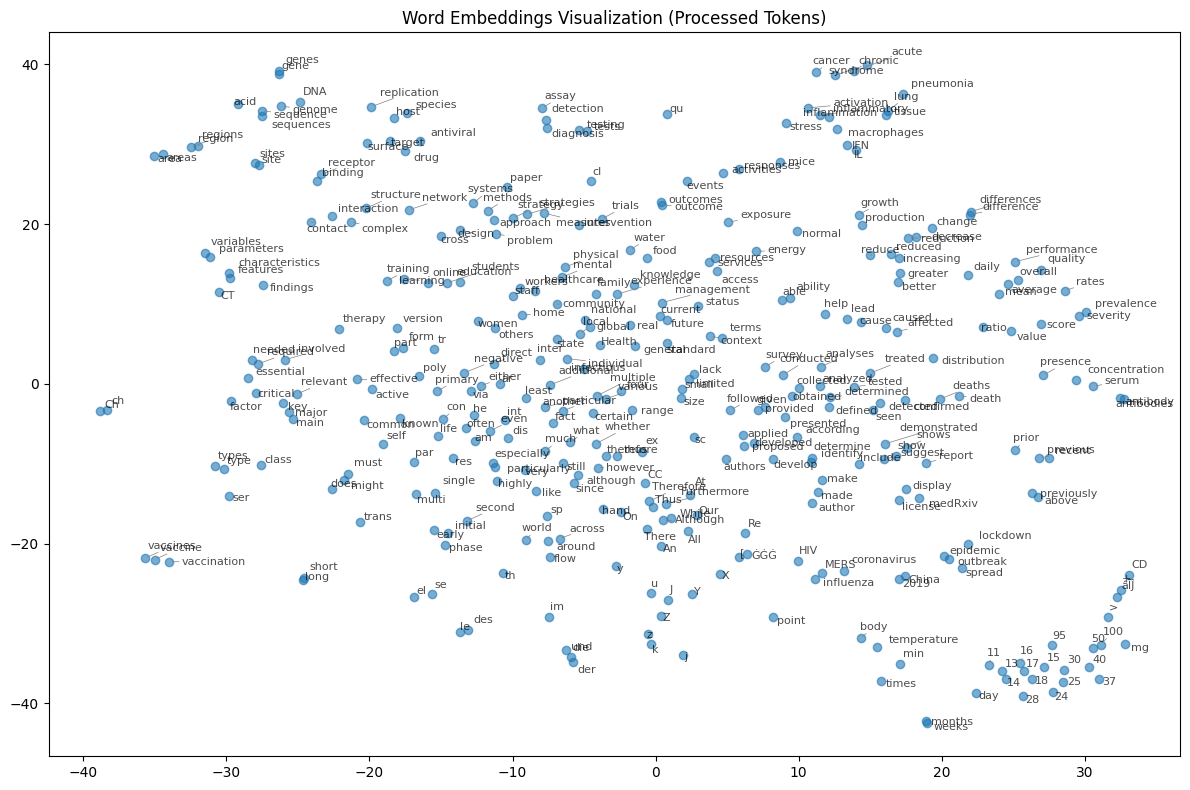

In [20]:
def process_and_visualize_embeddings(model_path, start_idx=500, end_idx=1000, perplexity=10):
    """
    加载模型并可视化词嵌入，保留带Ġ的词（去掉Ġ前缀），过滤掉不带Ġ的词
    """
    # 加载模型
    model = KeyedVectors.load(model_path)
    word2vec_model = model.wv

    # 处理词表：保留带Ġ的词（去掉前缀），过滤掉不带Ġ的词
    processed_words = []
    processed_vectors = []

    for word in word2vec_model.index_to_key[start_idx:end_idx]:
        if word.startswith('Ġ'):
            # 保留带Ġ的词，但去掉Ġ前缀
            processed_word = word[1:]  # 去掉Ġ前缀
            processed_words.append(processed_word)
            processed_vectors.append(word2vec_model[word])

    print(f"Original word count: {end_idx - start_idx}")
    print(f"Processed word count: {len(processed_words)}")
    gc.collect()
    if not processed_words:
        print("No words starting with 'Ġ'")
        return [], []

    # 转换为numpy数组
    word_vectors = np.array(processed_vectors)

    # 使用t-SNE降维
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_vectors = tsne.fit_transform(word_vectors)
    gc.collect()
    # 创建可视化
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.6)

    # 添加词标签（使用处理后的词）
    texts = []
    for i, word in enumerate(processed_words):
        texts.append(plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1],
                              word, fontsize=8, alpha=0.7))

    # 自动调整文本位置避免重叠
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    plt.title("Word Embeddings Visualization (Processed Tokens)")
    plt.tight_layout()
    plt.show()

    return processed_words, reduced_vectors


# 使用示例
model_path = "word2vec_model.model"
processed_words, vectors = process_and_visualize_embeddings(
    model_path=model_path,
    start_idx=500,
    end_idx=1000,
    perplexity=10
)

## Track 4.2 Visualize Biomedical Entities by t-SNE

2025-02-14 01:41:53,170 : INFO : loading KeyedVectors object from word2vec_model.model
2025-02-14 01:41:53,310 : INFO : loading wv recursively from word2vec_model.model.wv.* with mmap=None
2025-02-14 01:41:53,317 : INFO : setting ignored attribute cum_table to None


加载了 117 个医疗相关词语


2025-02-14 01:41:53,604 : INFO : Word2Vec lifecycle event {'fname': 'word2vec_model.model', 'datetime': '2025-02-14T01:41:53.603804', 'gensim': '4.3.2', 'python': '3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:46:43) [GCC 11.2.0]', 'platform': 'Linux-5.4.0-155-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


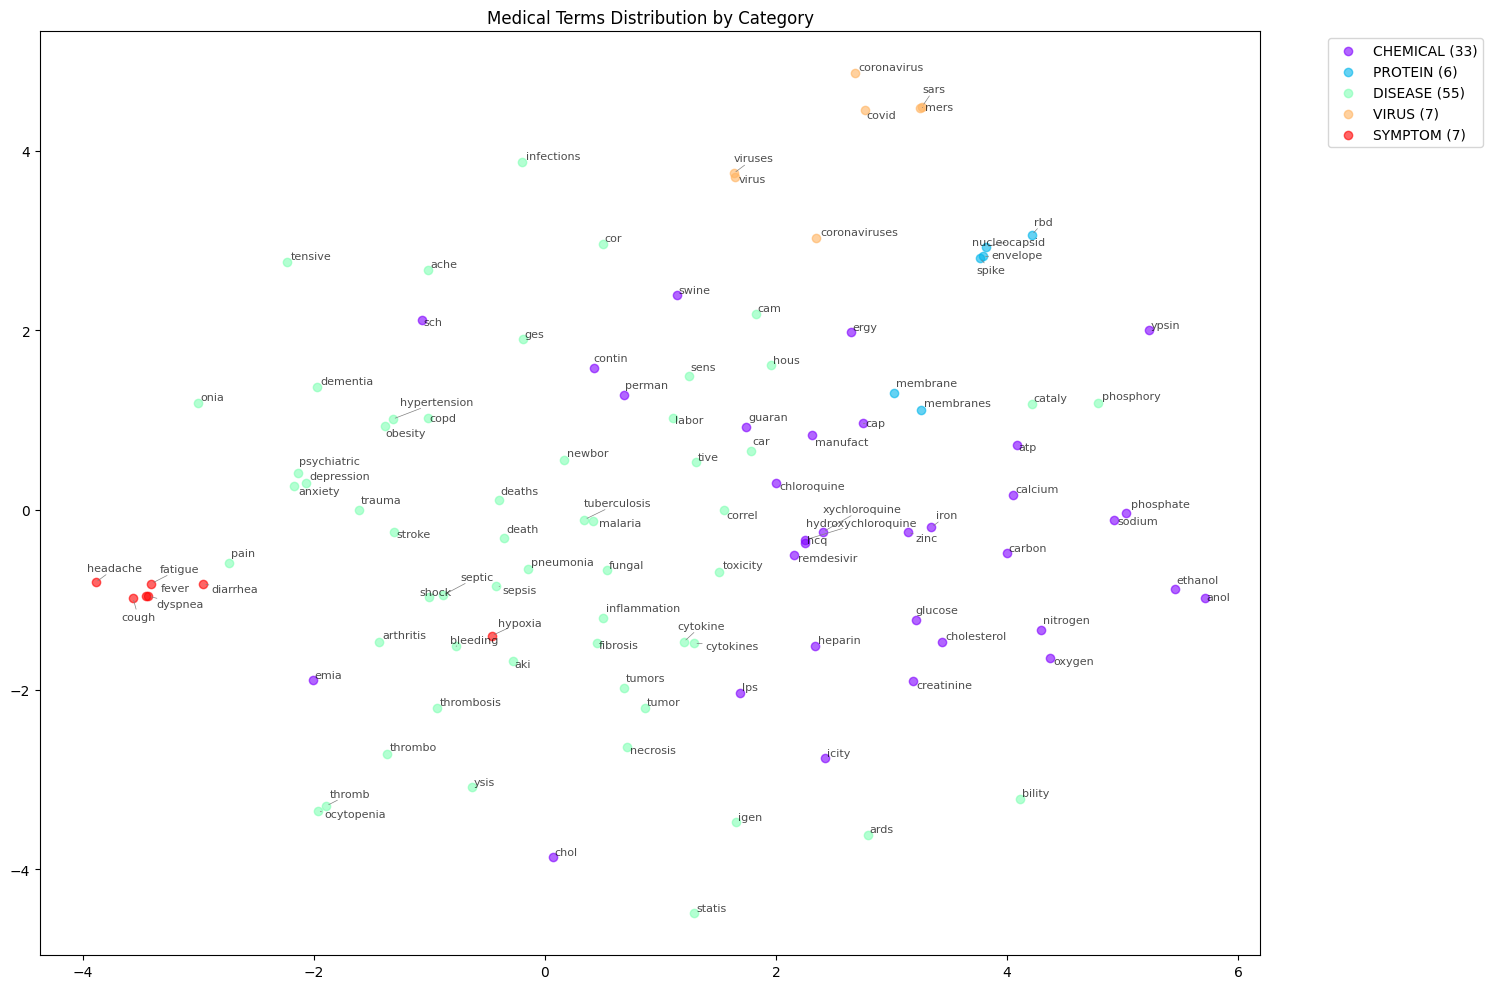


Amout of each class：
DISEASE: 55
CHEMICAL: 33
VIRUS: 7
SYMPTOM: 7
PROTEIN: 6


In [38]:
def load_medical_terms_with_categories(json_path: str) -> Tuple[set, Dict[str, str]]:
    """
    从JSON文件加载医疗术语及其类别，删除长度为 2 的单词
    """
    try:
        with open(json_path, 'r', encoding='utf-8') as file:
            terms_data = json.load(file)

        medical_terms = set()
        term_categories = {}

        for term, info in terms_data.items():
            # 处理带有Ġ前缀的词
            clean_term = term[1:] if term.startswith('Ġ') else term
            clean_term = clean_term.lower()

            # 删除长度为 2 的词
            if len(clean_term) == 2:
                continue

            medical_terms.add(clean_term)
            term_categories[clean_term] = info['category']

        print(f"加载了 {len(medical_terms)} 个医疗相关词语")

        return medical_terms, term_categories

    except FileNotFoundError:
        print(f"找不到医疗术语文件: {json_path}")
        return set(), {}
    except Exception as e:
        print(f"加载医疗术语时出错: {str(e)}")
        return set(), {}


def visualize_medical_terms(term_categories: Dict[str, str], model_path: str):
    """
    使用t-SNE可视化医疗术语的词向量分布

    Args:
        term_categories: 词语类别映射
        model_path: Word2Vec模型路径
    """
    # 加载Word2Vec模型
    model = KeyedVectors.load(model_path)
    word2vec_model = model.wv

    # 收集词向量和对应的类别
    words = []
    categories = []
    vectors = []

    for word in term_categories.keys():
        # 处理可能的Ġ前缀
        word_variants = [word, word.lower(), word.upper(), 'Ġ' + word, 'Ġ' + word.lower(), 'Ġ' + word.upper()]

        # 尝试获取词向量
        for variant in word_variants:
            try:
                if variant in word2vec_model:
                    vector = word2vec_model[variant]
                    category = term_categories[word.lower()]

                    words.append(word)
                    categories.append(category)
                    vectors.append(vector)
                    break
            except KeyError:
                continue


    if not vectors:
        print("没有找到可用的词向量")
        return

    # 转换为numpy数组
    vectors = np.array(vectors)

    # t-SNE降维
    tsne = TSNE(n_components=2, perplexity=min(30, len(vectors) - 1), random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)

    # 获取唯一的类别
    unique_categories = list(set(categories))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))
    category_color_dict = dict(zip(unique_categories, colors))

    # 创建图形
    plt.figure(figsize=(15, 10))

    # 为每个类别绘制散点图
    texts = []
    for category in unique_categories:
        # 获取该类别的点
        mask = [c == category for c in categories]
        cat_vectors = reduced_vectors[mask]
        cat_words = [w for w, c in zip(words, categories) if c == category]

        # 绘制散点图
        plt.scatter(cat_vectors[:, 0], cat_vectors[:, 1],
                    c=[category_color_dict[category]],
                    label=f"{category} ({len(cat_words)})",
                    alpha=0.6)

        # 添加词汇标注
        for i, word in enumerate(cat_words):
            text = plt.text(
                cat_vectors[i, 0],
                cat_vectors[i, 1],
                word,
                fontsize=8,
                alpha=0.7
            )
            texts.append(text)

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
    plt.title("Medical Terms Distribution by Category")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 打印类别统计
    print("\nAmout of each class：")
    category_counts = Counter(categories)
    for category, count in category_counts.most_common():
        print(f"{category}: {count}")


def process_file(medical_terms_json_path: str, model_path: str):
    """处理文件并可视化医疗术语"""
    try:
        # 加载医疗术语及其类别
        medical_terms, term_categories = load_medical_terms_with_categories(medical_terms_json_path)

        if not medical_terms:
            return


        # 可视化
        visualize_medical_terms(term_categories, model_path)

        return term_categories

    except Exception as e:
        print(f"处理文件时出错: {str(e)}")

medical_terms_json_path = r"medical_terms.json"
model_path = 'word2vec_model.model'
term_categories = process_file(medical_terms_json_path, model_path)

## Track 4.3 Co-occurence

Loaded 1322 words
正在将文件分块...


lines: 10000it [00:12, 784.20it/s]

Seperated into 33 chunks



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The


Most coocurrences are:
ġcoronavirus: 2193
ġdisease: 2151
ġhealth: 565
ġrespiratory: 468
ġacute: 402
ġsevere: 400
ġsyndrome: 374
ġduring: 370
ġinfection: 286
ġglobal: 242


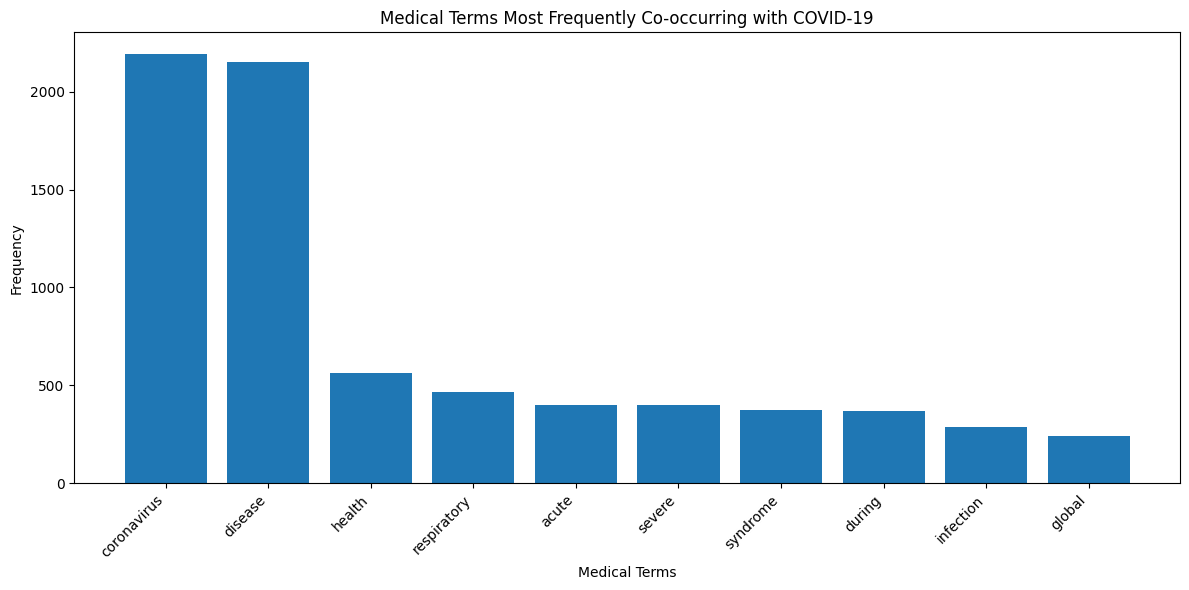

0

In [39]:
def load_medical_terms(file_path: str) -> set:
    """从文件加载医疗术语"""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            medical_terms = {line.strip().lower() for line in file if line.strip()}
        return medical_terms
    except FileNotFoundError:
        print(f"找不到医疗术语文件: {file_path}")
        return set()
    except Exception as e:
        print(f"加载医疗术语时出错: {str(e)}")
        return set()


def chunk_file(file_path: str, chunk_size: int = 10 * 1024 * 1024) -> list:
    """将文件分割成块"""
    chunks = []
    current_chunk = []
    current_size = 0

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in tqdm(file,desc = 'lines'):
            current_chunk.append(line)
            current_size += len(line.encode('utf-8'))

            if current_size >= chunk_size:
                chunks.append(''.join(current_chunk))
                current_chunk = []
                current_size = 0

        if current_chunk:  # 添加最后一个块
            chunks.append(''.join(current_chunk))

    return chunks


def find_covid_pattern(text: str, medical_terms: set) -> Counter:
    """查找包含 'COVID-19' 相关词的句子并分析医疗术语"""

    # 按 . , 分割句子
    sentences = text.replace('\n', ' ').split('.')
    sentences = [s for sentence in sentences for s in sentence.split(',')]

    medical_cooccurrence = []

    stop_words = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', '-', '19', 'covid', 'covid-19', 'covid19', 'from', 'positive', 'severe', 'clinical',
        'negative', 'other', 'time', 'high', 'related', 'associated', 'information', 'over', 'factor', 'specific'
    }

    for sentence in tqdm(sentences):
        words = sentence.split()
        cleaned_words = [word.strip().lower() for word in words if word.strip()]

        if any(covid_variant in cleaned_words for covid_variant in ['covid', 'covid-19', 'covid19']):
            medical_words = [
                word for word in cleaned_words
                if word in medical_terms and word not in stop_words
            ]
            medical_cooccurrence.extend(medical_words)

    return Counter(medical_cooccurrence)


def process_chunk(chunk: str, medical_terms: set) -> Counter:
    """处理单个文本块"""
    return find_covid_pattern(chunk, medical_terms)


def plot_medical_frequencies(word_freq: dict, top_n: int = 10):
    """绘制医疗术语频率统计图"""
    plt.figure(figsize=(12, 6))

    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
    if not top_words:
        print("没有找到医疗术语")
        return

    words, freqs = zip(*top_words)
    words = [word.replace('ġ','') for word in words]

    plt.bar(range(len(words)), freqs)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.title('Medical Terms Most Frequently Co-occurring with COVID-19')
    plt.xlabel('Medical Terms')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


def process_file(tokens_file_path: str, medical_terms_path: str):
    """使用多进程处理文件并分析医疗术语"""
    try:
        # 加载医疗术语
        medical_terms = load_medical_terms(medical_terms_path)
        print(f"Loaded {len(medical_terms)} words")

        if not medical_terms:
            return

        # 将文件分块
        print("正在将文件分块...")
        chunks = chunk_file(tokens_file_path)
        print(f"Seperated into {len(chunks)} chunks")

        # 设置进程数
        num_processes = 32  # 留出一个CPU核心

        # 创建进程池并处理
        with Pool(num_processes) as pool:
            # 使用partial固定medical_terms参数
            process_func = partial(process_chunk, medical_terms=medical_terms)

            # 使用tqdm显示进度
            results = list(tqdm(
                pool.imap(process_func, chunks),
                total=len(chunks),
                desc="Process speed"
            ))

        # 合并所有Counter结果
        medical_frequencies = Counter()
        for result in results:
            medical_frequencies.update(result)

        gc.collect()

        if not medical_frequencies:
            print("未找到相关医疗术语")
            return

        print("\nMost coocurrences are:")
        for word, freq in sorted(medical_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]:
            print(f"{word}: {freq}")

        plot_medical_frequencies(medical_frequencies)

        return medical_frequencies

    except FileNotFoundError:
        print(f"找不到文件: {tokens_file_path}")
    except Exception as e:
        print(f"处理文件时出错: {str(e)}")
    finally:
        gc.collect()


tokens_file_path = os.path.join(tokenized_dir,'merged_tokenized.txt')
medical_terms_path = 'entities_tokens.txt'
medical_frequencies = process_file(tokens_file_path, medical_terms_path)
gc.collect()

In [36]:
def load_medical_terms(file_path):
    """加载医疗相关词语"""
    medical_terms = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            # 将JSON数据转换为包含词语和类别的字典
            medical_terms = {term: info['category'] for term, info in data.items()}
    except Exception as e:
        print(f"读取JSON文件时出错: {e}")
        return {}
    return medical_terms

def find_medical_similarities(word2vec_model, target_word, medical_terms, topn=20):
    """找出与目标词最相似的医疗相关词语"""
    try:
        all_similar = word2vec_model.wv.most_similar(target_word, topn=100)  # 获取更多词，以便筛选
    except KeyError:
        print(f"词 '{target_word}' 不在模型词表中")
        return []

    # 筛选医疗相关词
    medical_similar = []
    for word, similarity in all_similar:
        if word in medical_terms:
            category = medical_terms[word]
            medical_similar.append((word, similarity, category))
            if len(medical_similar) >= topn:
                break

    return medical_similar

def main():
    # 加载模型
    model_path = "word2vec_model.model"
    word2vec_model = Word2Vec.load(model_path)

    # 加载医疗词语
    medical_terms_path = r"medical_terms.json"
    medical_terms = load_medical_terms(medical_terms_path)
    print(f"Loaded {len(medical_terms)} words")

    # 设置目标词
    target_word = "ĠCOVID"
    alternative_words = ["covid", "COVID", "ĠCOVID", "ĠCovid"]

    # 确保词在词表中
    if target_word not in word2vec_model.wv.key_to_index:
        print(f"'{target_word}' 不在词表中")
        for word in alternative_words:
            if word in word2vec_model.wv.key_to_index:
                target_word = word
                print(f"使用替代词 '{word}'")
                break
        else:
            print("未找到相关词")
            return

    # 获取相似的医疗词语
    similar_words = find_medical_similarities(word2vec_model, target_word, medical_terms)

    # 打印结果
    print(f"\n '{target_word}' Most relevant are:")
    print("\n{:<20} {:<10} {:<10}".format("Word", "Similarity", "Category"))
    print("-" * 40)
    for word, similarity, category in similar_words:
        if 'Ġ' in word:
            word = word.split('Ġ')[1]
        print("{:<20} {:.4f} {:<10}".format(word, similarity, category))

main()

2025-02-14 01:39:46,846 : INFO : loading Word2Vec object from word2vec_model.model
2025-02-14 01:39:46,960 : INFO : loading wv recursively from word2vec_model.model.wv.* with mmap=None
2025-02-14 01:39:46,966 : INFO : setting ignored attribute cum_table to None
2025-02-14 01:39:47,246 : INFO : Word2Vec lifecycle event {'fname': 'word2vec_model.model', 'datetime': '2025-02-14T01:39:47.246257', 'gensim': '4.3.2', 'python': '3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:46:43) [GCC 11.2.0]', 'platform': 'Linux-5.4.0-155-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


Loaded 184 words

 'ĠCOVID' Most relevant are:

Word                 Similarity Category  
----------------------------------------
COVID                0.5488 VIRUS     
SARS                 0.4951 VIRUS     
coronavirus          0.3956 VIRUS     
Coronavirus          0.3882 VIRUS     
thrombo              0.3869 DISEASE   
ARDS                 0.3833 DISEASE   
MERS                 0.3786 VIRUS     
pneumonia            0.3650 DISEASE   
psychiatric          0.3152 DISEASE   
deaths               0.3115 DISEASE   
